# Correlation analysis
'''
Created on Tue 03 Mar 2020'''



This Notebook is intended to do the entire correlation matrix analysis 
for the different trials, object configuration, object exploration.

## Importation of libraries and definition of specific data to use

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
import scipy
cmap = cm.jet

Define mouse to analize as well as preprocessing analysis versions

mouse -> mouse identity //
decoding_v  -> decoding version //
motion_correction_v - > motion correction version. 100 is aligned one. //
alignment_v -> alignment version//
equalization_v -> equalization version//
source_extraction_v -> source extraction version//
component_evaluation_v -> component evaluation version//
registration_v -> registration version//

sf = 10 -> signal sampling frequency //
re_sf= 20 -> resample integer (will take one every re_sf point ans use the mean)

In [2]:
mouse = 56165             ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 100 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 1           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 1        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 20                 ## value of resampling

sessions = [1,2,4]       ## sessions for this particular mouse
session_now = 1              ## session that will run

if session_now == 1:
    task = 'OVERLAPPING'
else:
    if session_now == 2:
        task = 'STABLE'
    else:
        task = 'RANDOM'

Define all necesary directories from calcium activity, behavioural data, objects position and timeline

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'

## Compare correlation matrix in multiple conditions

For comparison of multiple sessions, load all sessions and normalize the data trial by trial

In [4]:
correlation_matrix = []   ## correlation matrix that will contain all the correlation matrix of multiple sessions
task_list = []            ## condition list
for session in [1,2,4]:

    if session == 1:
        task = 'OVERLAPPING'
    else:
        if session == 2:
            task = 'STABLE'
        else:
            task = 'RANDOM'

    file_name_session_1 = 'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_1_v'+ f'{decoding_v}'+'.4.'+f'{100}'+\
                          '.'+f'{alignment_v}'+'.'+ f'{equalization_v}' +'.' + f'{source_extraction_v}'+'.' + \
                          f'{component_evaluation_v}' +'.'+ f'{registration_v}' + '.npy'
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_1_v'+ f'{decoding_v}'+'.1.'+f'{1}'+\
                          '.'+f'{0}'+ '.pkl'
    beh_file_name_1 = 'mouse_'+f'{mouse}'+'_session_'+f'{session}'+'_event_'+f'{re_sf}'+'.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    ##normalize neural activity
    neural_activity1, timeline_1 = stats.normalize_neural_activity(activity=activity, timeline=timeline_info)
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,re_sf=re_sf)
    correlation_matrix.append(stats.corr_matrix(neural_activity = resample_neural_activity_mean))
    #cov_matrix.append(stats.cov_matrix(neural_activity = resample_neural_activity_mean))
    task_list.append(task)


Define path for new figures and plot correlation matrix for multiple conditions for this mouse

/home/sebastian/Documents/Melisa/neural_analysis/src/figures.py:65: RuntimeWarning: invalid value encountered in log10
  images.append(axes[i, j].imshow(np.log10(matrix_list[counter]), cmap='viridis'))


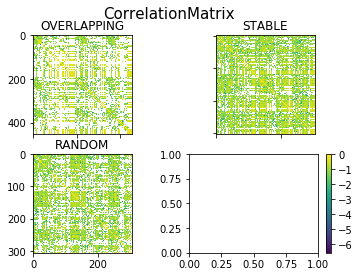

In [5]:
correlation_fig_path =  os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/' \
                                                    'correlation_matrix_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                        '_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_matrix_conditions(matrix_list = correlation_matrix, save_path = correlation_fig_path,
                                        title = 'CorrelationMatrix' , conditions = task_list)


## Correlation matrix in different behavioural conditions

Behavioural condions here refers to resting periods (in between trials), non exploration periods (time inside the arena but not exploring the objects) and different objects exploration periods. Objects exploration are refered as the position they occupaid in the arena (LL, LR, UL, UR).
Two main figures are ploted from here, the correlation matrix for all behavioural conditions and the statistical analysis of the correlation values in those correlation matrix. 

First define all the files paths, and the load and normalize

In [6]:
# define all relevant files names
session = session_now
file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{100}' + \
                      '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                      f'{component_evaluation_v}' + '.' + f'{registration_v}' + '.npy'
time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.1.' + f'{1}' + \
                      '.' + f'{0}' + '.pkl'
beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '.npy'


In [7]:
##load activity and timeline
activity = np.load(file_directory + file_name_session_1)
timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
timeline_info = pickle.load(timeline_file)
##normalize neural activity
neural_activity1, timeline_1 = stats.normalize_neural_activity(activity=activity, timeline=timeline_info)
##downsample neural activity
resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,
                                                                                    re_sf=re_sf)
## LOAD BEHAVIOUR
behaviour = np.load(behaviour_dir + beh_file_name_1)
#c = np.linspace(0, 20, len(behaviour))
neural_activity_new= []
testing = []
reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
resample_timeline = timeline_1/re_sf


Separate parts of the signal that belong to different bahavioural conditions. 

This activity will be saved in the list nerual_activity_new, and the correlation matrix will be computed and saved in corr_matrix list.

In [8]:
#separate neural activity that belongs to traiing without testing trial
vector = resample_neural_activity_mean[:, :int(timeline_1[40])]
vector_beh = resample_beh1 [:int(resample_timeline[40])]
#define list where data will be saved
neural_activity_new = []
corr_matrix = []
for i in range(6):
    neural_activity_new.append(vector[:,np.where(vector_beh== i)])
    corr_matrix.append(stats.corr_matrix(neural_activity = neural_activity_new[i][:,0,:]))
    #corr_matrix.append(stats.cov_matrix(neural_activity = neural_activity_new[i][:,0,:]))

Plot correlation matrix for the different behavioural conditions

/home/sebastian/Documents/Melisa/neural_analysis/src/figures.py:93: RuntimeWarning: divide by zero encountered in log10
  images.append(axes[i, j].imshow(np.log10(corr_matrix_list[i * 2 + j]), cmap='viridis'))
/home/sebastian/Documents/Melisa/neural_analysis/src/figures.py:93: RuntimeWarning: invalid value encountered in log10
  images.append(axes[i, j].imshow(np.log10(corr_matrix_list[i * 2 + j]), cmap='viridis'))


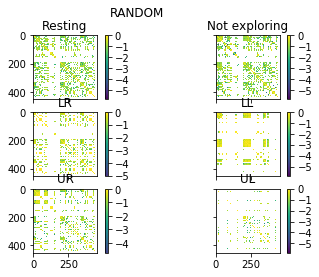

In [9]:
# define file name to save figure and plot
correlation_behaviour_path = os.environ['PROJECT_DIR'] + 'neural_analysis/data/process/figures/' \
                             'correlation_matrix_task_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'.png'

figs.plot_correlation_matrix_behaviour(corr_matrix_list = corr_matrix, path_save = correlation_behaviour_path, title = task)



Generate statistics over the correlation matrix values. Compute distribution, mean and std values and compare the different conditions by computing correlation between correlation matrix and KLD betwween the distributions. 

/home/sebastian/anaconda3/lib/python3.6/site-packages/matplotlib-2.2.2-py3.6-linux-x86_64.egg/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


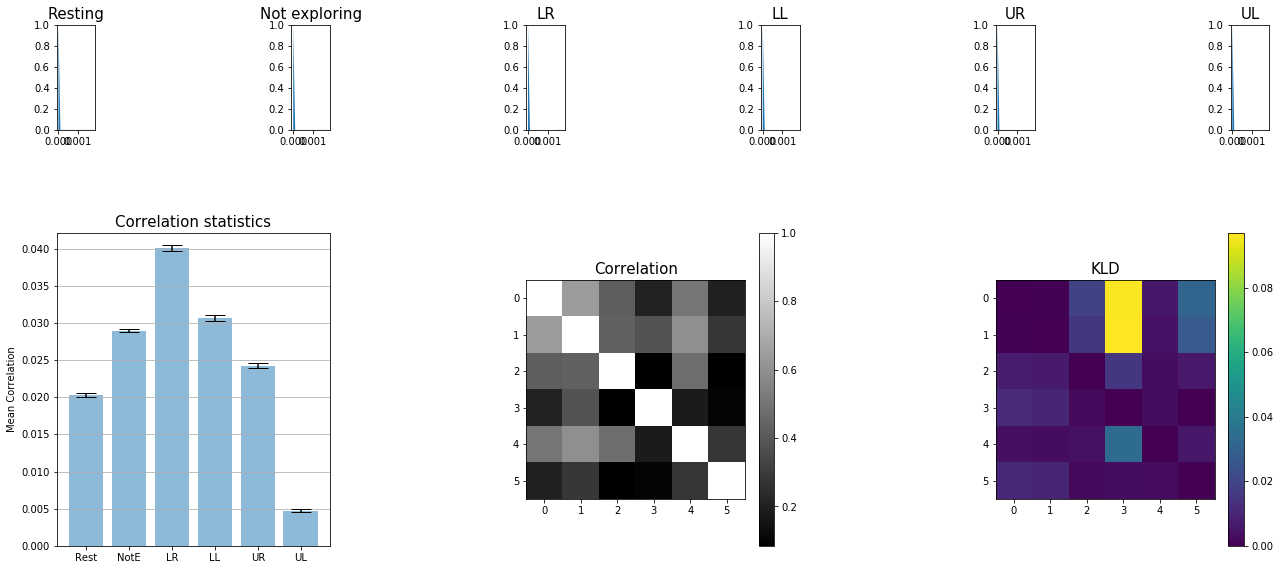

In [10]:
# define file name to save figure and plot
correlation_stats_path = os.environ['PROJECT_DIR'] + 'neural_analysis/data/process/figures/' \
                                                     'correlation_statistics_mouse_'+f'{mouse}'+'_session_'\
                         +f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_statistics_behaviour(corr_matrix=corr_matrix, path_save=correlation_stats_path)

## Correlation matrix over days and trials

Analysis of the evaluation of the correlation matrix over different days of the experiment and over different trials.

### Days of the experiment

In [11]:
# Separate neural activity belonging to different days of the experiment, considering as different the resting
# and the trial parts.

neural_activity1_days = []
time_length = np.diff(resample_timeline)
for i in range(4):
    day_matrix = np.zeros((neural_activity1.shape[0],int(np.sum(time_length[i*10:(i+1)*10:2]))))
    start_time = 0
    for j in range(0,10,2):
        trial = i*10 + j
        day_matrix[:,start_time:start_time+ int(time_length[trial])] = \
            neural_activity1[:,int(timeline_1[trial]):int(timeline_1[trial]) + int(time_length[trial])]
        start_time = start_time + int(time_length[trial])
    neural_activity1_days.append(day_matrix)

neural_activity1_resting_days = []
time_length = np.diff(timeline_1)
for i in range(4):
    day_matrix = np.zeros((neural_activity1.shape[0],int(np.sum(time_length[i*10+1:(i+1)*10+1:2]))))
    start_time = 0
    for j in range(1,10,2):
        trial = i*10 + j
        day_matrix[:,start_time:start_time+ int(time_length[trial])] = \
            neural_activity1[:,int(timeline_1[trial]):int(timeline_1[trial]) + int(time_length[trial])]
        start_time = start_time + int(time_length[trial])
    neural_activity1_resting_days.append(day_matrix)

neural_activity1_resting_testing = neural_activity1[:,int(timeline_1[-2]):int(timeline_1[-1])]
neural_activity1_testing = neural_activity1[:,int(timeline_1[-3]):int(timeline_1[-2])]


Compute correlation matrix for the different subsets of neural activity, including separately the testing day. Correlation matrix are saved in lists. 

In [12]:
corr_matrix_days = []
for i in range(4):
    corr_matrix_days.append(stats.corr_matrix(neural_activity = neural_activity1_days[i]))
    #corr_matrix_days.append(stats.cov_matrix(neural_activity = neural_activity1_days[i]))

corr_matrix_days.append(stats.corr_matrix(neural_activity = neural_activity1_testing))
#corr_matrix_days.append(stats.cov_matrix(neural_activity = neural_activity1_testing))

corr_matrix_resting_days = []
for i in range(4):
    corr_matrix_resting_days.append(stats.corr_matrix(neural_activity = neural_activity1_resting_days[i]))
    #corr_matrix_resting_days.append(stats.cov_matrix(neural_activity = neural_activity1_resting_days[i]))
corr_matrix_resting_days.append(stats.corr_matrix(neural_activity = neural_activity1_resting_testing))
#corr_matrix_resting_days.append(stats.cov_matrix(neural_activity = neural_activity1_resting_testing))

For analyzing the correlation matrix over days plot statistics and correlations over them. Here we plot the mean values (and error of the mean) of correlation matrix over multiple days, the correlation between different days correlation matrix and the Kullback-Leiber Divergence of the distributions of correlation values during diferent days. Note: Correlation of correlation matrix is simetric while KLD is not!

/home/sebastian/anaconda3/lib/python3.6/site-packages/matplotlib-2.2.2-py3.6-linux-x86_64.egg/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


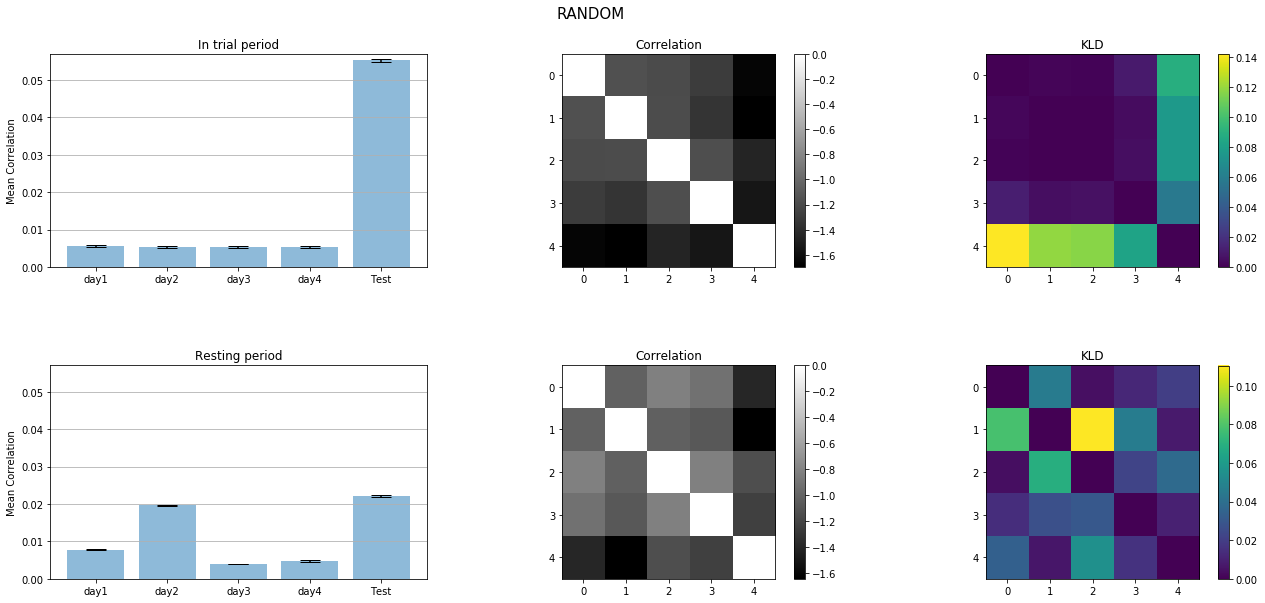

In [13]:
# define the path to save the figure and plot
correlation_path = '/home/sebastian/Documents/Melisa/neural_analysis/data/process/figures/' \
                   'correlation_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_statistics_learning(corr_matrix1=corr_matrix_days, corr_matrix2=corr_matrix_resting_days,
                                     path_save=correlation_path, title=task)


### Trials of the experiment

Fisrt separate the data corresponding to different trials by using the timeline data, and then compute correlation matrix for each trial.

In [14]:
# Separate neural activity for different trials and save in the neural_activity_days and
# neural_activity_resting_days lists.

neural_activity1_days = []
time_length = np.diff(timeline_1)
for i in range(0,42,2):
    trial_matrix = neural_activity1[:,int(timeline_1[i]):int(timeline_1[i]) + int(time_length[i])]
    neural_activity1_days.append(trial_matrix)

neural_activity1_resting_days = []
for i in range(1,42,2):
    trial_matrix = neural_activity1[:,int(timeline_1[i]):int(timeline_1[i]) + int(time_length[i])]
    neural_activity1_resting_days.append(trial_matrix)


In [15]:
corr_matrix_days = []
for i in range(21):
    corr_matrix_days.append(stats.corr_matrix(neural_activity = neural_activity1_days[i]))
    #corr_matrix_days.append(stats.cov_matrix(neural_activity = neural_activity1_days[i]))

corr_matrix_resting_days = []
for i in range(21):
    corr_matrix_resting_days.append(stats.corr_matrix(neural_activity = neural_activity1_resting_days[i]))
    #corr_matrix_resting_days.append(stats.cov_matrix(neural_activity = neural_activity1_resting_days[i]))

/home/sebastian/Documents/Melisa/neural_analysis/src/figures.py:328: RuntimeWarning: invalid value encountered in log10
  x = ax1.imshow(np.log10(corr_of_corr),cmap = 'gray')
/home/sebastian/anaconda3/lib/python3.6/site-packages/matplotlib-2.2.2-py3.6-linux-x86_64.egg/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


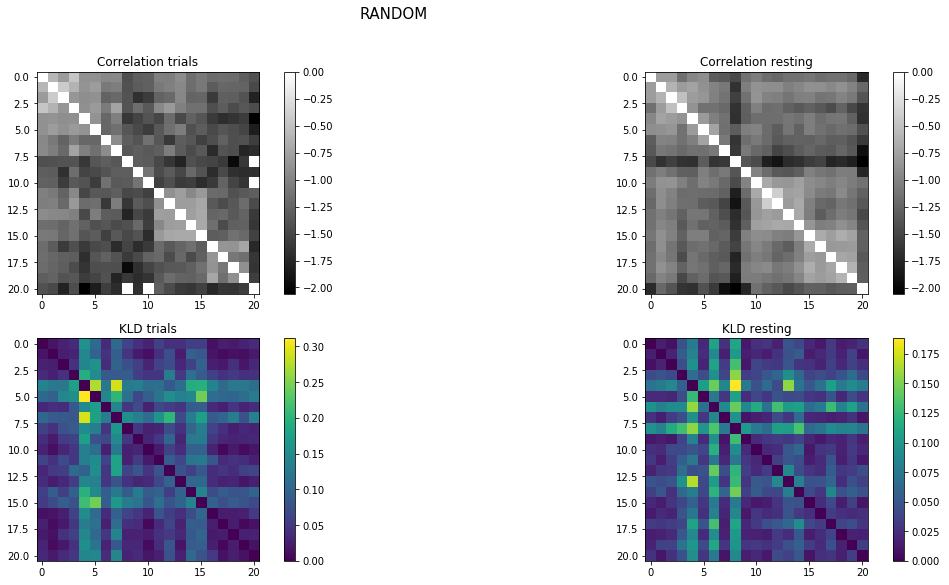

In [16]:
# define figure save path and plot
correlation_path = '/home/sebastian/Documents/Melisa/neural_analysis/data/process/figures/' \
                   'correlation_mouse_trials_'+f'{mouse}'+'_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'

figs.plot_correlation_statistics_trials(corr_matrix1=corr_matrix_days, corr_matrix2=corr_matrix_resting_days,
                                     path_save=correlation_path, title=task)


## Correlation matrix and object positions

Now we focus in the relationship between the neural correlation matrix and the object positions and repetitions of object positions (as enviromnetal configuration changes). The key idea is to search for a neural representation of environmental configuration. 

In general there are 6 posible configurations. In Overlapping condition only three are explored, in stable only one and random has the 6 posible configurations. 

We separated the analysis in two: conting number of overlapping (0, 1 or 2) objects in multiple trials or exact repetition of object configuration in different trials. For this we used correlation matrix computed in the previous steps for trial by trial analysis.


### Overlapping analysis. 

Using object position information to check the number of overlapping with other trials. 

Correlation matrix are the same as before but here we also plot the overlapping matrix that represents when teh condition is the same, similar or totaly different in between two trials. 


In [17]:
# load overlapping information
overlapping_objects_file = objects_dir + 'overlapping_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'
overlapping_matrix = np.load(overlapping_objects_file)

/home/sebastian/Documents/Melisa/neural_analysis/src/figures.py:386: RuntimeWarning: invalid value encountered in log10
  x = ax1.imshow(np.log10(corr_of_corr1), cmap='gray')
/home/sebastian/anaconda3/lib/python3.6/site-packages/matplotlib-2.2.2-py3.6-linux-x86_64.egg/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


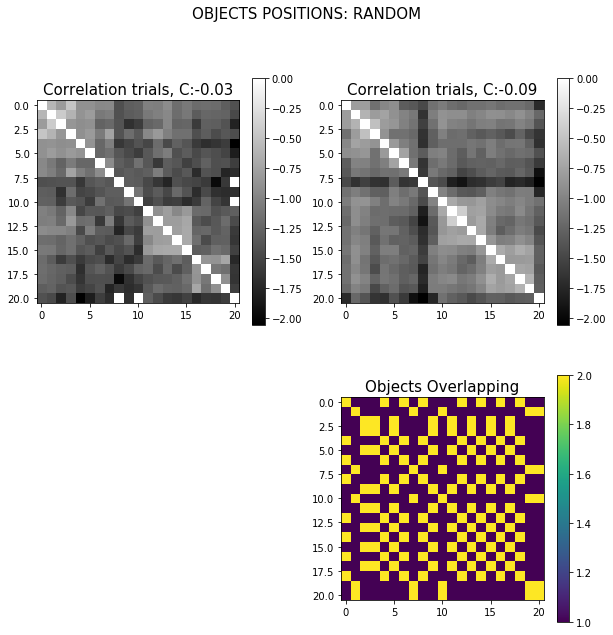

In [18]:
# define path to save figura and plot
objects_fig_path = os.environ['PROJECT_DIR'] + 'neural_analysis/data/process/figures/' \
                                               'correlation_with_object_position_'+f'{mouse}'+\
                   '_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_statistics_objects(corr_matrix1=corr_matrix_days, corr_matrix2=corr_matrix_resting_days,
                                         overlapping_matrix=overlapping_matrix, path_save=objects_fig_path,
                                    title=task)

### Enviromental configuration analysis

Now we analyze the two object position in simultaneous as a environment configurations. For that we compute the correlation matrix as before, but for visualization we reaorganized it so trials that belong to the same configuration are together (as represented in the configuration matrix, that shows one for same configuration and cero for different in between trials). 

As before we use the correlation matrix computed previously for trial by trial correlation matrix analysis. 

In [19]:
# load the information about object configurations. This files have the configuration vector
# (a vector with values 1 to 6 for the different configurations) and the configuration matrix 
# (a matrix that has ones for trials with the same configuration and cero for different)

condition_objects_file = objects_dir + 'condition_vector_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'
condition_objects_file_matrix = objects_dir + 'condition_matrix_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'

condition_vector= np.load(condition_objects_file)
condition_matrix= np.load(condition_objects_file_matrix)

In [20]:
#reorder trials acording to conditon (objects configuration)
new_corr_matrix_days = []
new_corr_matrix_resting_days = []
new_condition_matrix = np.zeros((condition_vector.shape[0],condition_vector.shape[0]))
counter = 0
repetitions = []
for condition in range(1,7):
    positions = np.where(condition_vector == condition)
    if positions[0].shape[0] > 0:
        repetitions.append(positions[0].shape[0])
        for j in positions[0]:
            new_corr_matrix_days.append(corr_matrix_days[j])
            new_corr_matrix_resting_days.append(corr_matrix_resting_days[j])
            counter = counter +1

rep_cumsum = np.zeros((len(repetitions)+1))
rep_cumsum[1:]= np.cumsum(repetitions)
for rep in range(len(repetitions)):
    for i in range(int(rep_cumsum[rep]),int(rep_cumsum[rep+1])):
        for j in range(int(rep_cumsum[rep]),int(rep_cumsum[rep+1])):
            new_condition_matrix[i,j] = 1

/home/sebastian/Documents/Melisa/neural_analysis/src/figures.py:386: RuntimeWarning: invalid value encountered in log10
  x = ax1.imshow(np.log10(corr_of_corr1), cmap='gray')
/home/sebastian/anaconda3/lib/python3.6/site-packages/matplotlib-2.2.2-py3.6-linux-x86_64.egg/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


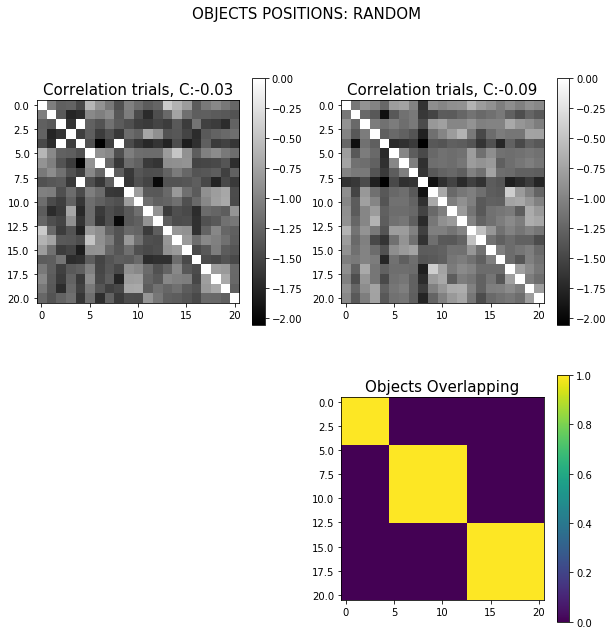

In [21]:
# define path to save figura and plot
objects_fig_path = os.environ['PROJECT_DIR'] + 'neural_analysis/data/process/figures/' \
                                               'correlation_with_object_configuration_'+f'{mouse}'+\
                   '_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'
figs.plot_correlation_statistics_objects(corr_matrix1=new_corr_matrix_days, corr_matrix2=new_corr_matrix_resting_days,
                                         overlapping_matrix=new_condition_matrix, path_save=objects_fig_path,
                                    title=task)

## Evolution of correlation with resting over trials

Here the question is whether there is any correlation between pre and post trial activity. So, we computed the correlation between the correlation matrix during the trial and the pre and post resting activity. 

For this, only correlation matrix computed before for trial by trial analysis are requird (for trial and resting periods). 

/home/sebastian/anaconda3/lib/python3.6/site-packages/matplotlib-2.2.2-py3.6-linux-x86_64.egg/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


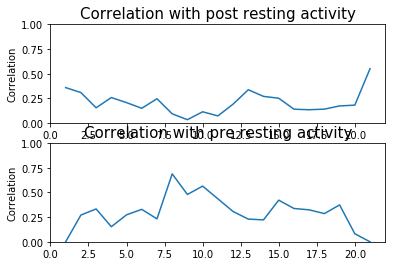

In [21]:
# define path to save the figure and plot
corr_evol_path = os.environ['PROJECT_DIR'] + 'neural_analysis/data/process/figures/' \
                                               'correlation_with_resting_evoluction_'+f'{mouse}'+\
                   '_session_'+f'{session}'+'_binsize_'+f'{re_sf}'+'.png'

figs.plot_correlation_with_resting_evolution(corr_matrix1 = corr_matrix_days, corr_matrix2 =corr_matrix_resting_days,path_save = corr_evol_path)
